# RICE LEAF DISEASES

# Business Case

Introduction:
Rice is a staple food for millions worldwide, and its yield is significantly impacted by various diseases. 
Accurate and early detection of rice leaf diseases can help improve crop management and increase productivity. 
This case study explores the feasibility of using deep learning models, specifically Convolutional Neural Networks (CNNs),
to classify three major rice leaf diseases: Bacterial Leaf Blight, Brown Spot, and Leaf Smut.
    
Problem Statement:
The primary challenge in rice disease classification is the accurate and automated identification of infected leaves. 
Traditional methods rely on manual inspection by farmers or experts, which can be time-consuming and prone to human error. 
The goal of this study is to develop a robust image classification model to automate disease detection and assist farmers 
in making informed decisions for disease management.

Business Objectives:
Automate disease detection: Reduce dependency on manual inspection and expert analysis.
Improve agricultural productivity: Enable early intervention to prevent the spread of diseases.
Reduce economic losses: Timely detection can help farmers take corrective actions and minimize crop damage.
Develop a scalable AI-based solution: Implement a model that can be integrated into a mobile application for real-time disease detection.

Business Impact:
Enhanced Decision-Making: Farmers can take immediate action upon disease detection.
Scalability: AI-powered solutions can be extended to other crops and regions.
Cost Savings: Reducing dependency on expert consultations lowers operational costs.

# Import Required Libraries


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
# Define dataset path
dataset_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data"

# Check if the path exists
if not os.path.exists(dataset_path):
    raise ValueError(f"Path does not exist: {dataset_path}")


# Data Preprocessing

In [3]:
# Set image dimensions
img_width = 64
img_height = 164


In [4]:
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [5]:
images = []
labels = []

# Load images from each class folder
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_folder):
        print(f"Processing {class_name}...")
        
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            
            if os.path.isfile(image_path):
                img = cv2.imread(image_path)
                
                if img is not None:
                    img = cv2.resize(img, (img_width, img_height))
                    images.append(img)
                    labels.append(class_name)  # Use folder name as class label
                else:
                    print(f"Skipping unreadable image: {image_path}")

# Convert to NumPy arrays
X = np.array(images, dtype='float32')
y = np.array(labels)

print(f"Loaded {len(X)} images with labels {len(y)}")

Processing Bacterial leaf blight...
Processing Brown spot...
Processing Leaf smut...
Loaded 119 images with labels 119


# Displaying Images

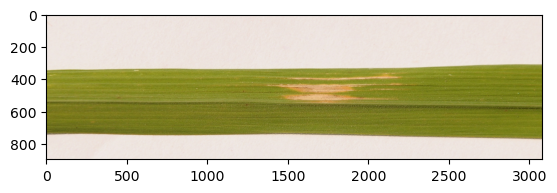

In [6]:
image = plt.imread(r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Bacterial leaf blight\DSC_0400.jpg")
plt.imshow(image)

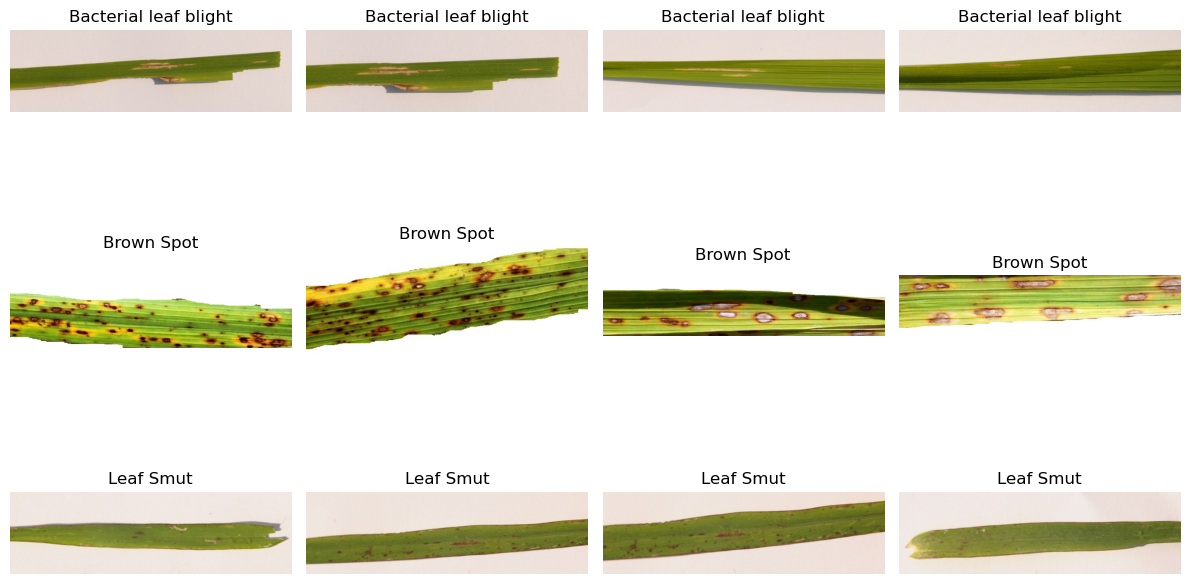

In [7]:
import matplotlib.pyplot as plt
import os
import glob

# Define paths for different disease categories
base_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data"
disease_classes = ["Bacterial leaf blight", "Brown Spot", "Leaf Smut"]

# Number of images per class to display
num_images = 4

# Create a figure to display images
fig, axes = plt.subplots(len(disease_classes), num_images, figsize=(12, 8))

for i, disease in enumerate(disease_classes):
    # Get image file paths from each disease class
    image_paths = glob.glob(os.path.join(base_path, disease, "*.jpg"))[:num_images]

    for j, img_path in enumerate(image_paths):
        image = plt.imread(img_path)
        axes[i, j].imshow(image)
        axes[i, j].axis("off")  # Hide axes
        axes[i, j].set_title(f"{disease}")

# Adjust layout and show the images
plt.tight_layout()
plt.show()


In [8]:
image.shape

(897, 3081, 3)

# Split Data into Training and Testing Sets


In [9]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=3)  # One-hot encode labels

# Normalize images (convert pixel values to range [0, 1])
X = X.astype('float32') / 255.0  # ✅ Ensures correct data type before normalization

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Test Set: {X_test.shape}, {y_test.shape}")


Training Set: (95, 164, 64, 3), (95, 3)
Test Set: (24, 164, 64, 3), (24, 3)


In [10]:
X.shape, y.shape

((119, 164, 64, 3), (119, 3))

# Data Augmentation

Data Augmentation enhances a dataset by applying transformations like rotation, flipping, scaling, and brightness adjustments to images. It improves model generalization and reduces overfitting by introducing variations in training samples. This technique is crucial for deep learning tasks with limited data, such as medical or agricultural image classification.   

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=60,  # Increased
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)


# Model Architecture

Model Architecture refers to the design and structure of a deep learning model, including layers, activation functions, and connections. It defines how data flows through the model, from input to output, enabling feature extraction and classification. A well-designed architecture, like CNNs for images or Transformers for NLP, optimizes performance and accuracy. 

# CNN Model

A Convolutional Neural Network (CNN) is a deep learning model specialized for image processing and pattern recognition. It uses convolutional layers to extract features, pooling layers to reduce dimensions, and fully connected layers for classification. CNNs are widely used in tasks like image recognition, object detection, and medical diagnosis. 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set image dimensions
img_height = 64  
img_width = 164  

# Define Custom CNN model
custom_cnn_model = Sequential()

# First Conv Block
custom_cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
custom_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Second Conv Block
custom_cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
custom_cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Third Conv Block
custom_cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
custom_cnn_model.add(MaxPooling2D(pool_size=(2,2)))
custom_cnn_model.add(Dropout(0.3))  # Increased Dropout

# Flatten layer
custom_cnn_model.add(Flatten())

# Fully Connected Layers
custom_cnn_model.add(Dense(256, activation='relu'))  # Increased to 256
custom_cnn_model.add(Dropout(0.4))  # Increased Dropout

# Output Layer
custom_cnn_model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile model
custom_cnn_model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
custom_cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 164, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 82, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,243,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,337,155 (20.36 MB)

 Trainable params: 5,337,155 (20.36 MB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation
The model was compiled using the RMSprop optimizer and the sparse categorical crossentropy loss function. The choice of optimizer and loss function was guided by the nature of the classification task, where the goal was to assign each input image to one of several classes.

In [13]:
# Define optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.8, epsilon=1e-08, decay=0.0)

# Compile model
custom_cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training
The model was trained using the training data, with the best model weights being saved during training using the ModelCheckpoint callback. This ensures that the best version of the model, as determined by its performance on the validation set, is preserved.

In [14]:
# Save the best model weights
checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

# Train the model
history_cnn = custom_cnn_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=200,  # Reduce from 200 to prevent overfitting
    callbacks=[checkpointer],
    verbose=1
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3028 - loss: 1.5908
Epoch 1: val_loss improved from inf to 1.09512, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.3008 - loss: 1.6278 - val_accuracy: 0.3333 - val_loss: 1.0951
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3918 - loss: 1.1169
Epoch 2: val_loss improved from 1.09512 to 1.09179, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.3807 - loss: 1.1238 - val_accuracy: 0.3750 - val_loss: 1.0918
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4216 - loss: 1.0977
Epoch 3: val_loss improved from 1.09179 to 1.06675, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.4215 - loss: 1.0976 - val_accuracy: 0.3750 - val_loss: 1.0668
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3696 - loss: 1.1098
Epoch 4: val_loss did not improve from 1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.4911 - loss: 0.9833 - val_accuracy: 0.6250 - val_loss: 0.7275
Epoch 26/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6218 - loss: 0.8846
Epoch 26: val_loss did not improve from 0.72751
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6295 - loss: 0.8861 - val_accuracy: 0.5417 - val_loss: 0.9395
Epoch 27/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4087 - loss: 1.0256
Epoch 27: val_loss did not improve from 0.72751
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4170 - loss: 1.0210 - val_accuracy: 0.7917 - val_loss: 0.7680
Epoch 28/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5325 - loss: 0.9725
Epoch 28: val_loss did not improve from 0.72751
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5389 - loss: 0.9698 - val_accuracy: 0.6667 - val_loss: 0.8271
Epoch 29/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5727 - loss: 0.8952
Epoch 29: val_loss improved from 0.72751 to 0.71516,

Epoch 51/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5401 - loss: 0.8740
Epoch 51: val_loss did not improve from 0.53958
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.5446 - loss: 0.8700 - val_accuracy: 0.6250 - val_loss: 0.7921
Epoch 52/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5716 - loss: 0.9729
Epoch 52: val_loss did not improve from 0.53958
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5840 - loss: 0.9466 - val_accuracy: 0.7917 - val_loss: 0.5600
Epoch 53/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7277 - loss: 0.7016
Epoch 53: val_loss did not improve from 0.53958
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7195 - loss: 0.7088 - val_accuracy: 0.8333 - val_loss: 0.5405
Epoch 54/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5874 - loss: 0.7451
Epoch 54: val_loss did not improve from 0.53958
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.5932 - loss: 0.7466 - val_accuracy: 0.7917 - val_loss: 0.5651
Epoc

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7385 - loss: 0.5742 - val_accuracy: 0.7500 - val_loss: 0.5098
Epoch 102/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6252 - loss: 0.8298
Epoch 102: val_loss did not improve from 0.38428
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6268 - loss: 0.8107 - val_accuracy: 0.7917 - val_loss: 0.4632
Epoch 103/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6973 - loss: 0.6046
Epoch 103: val_loss improved from 0.38428 to 0.35346, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.7072 - loss: 0.5918 - val_accuracy: 0.9167 - val_loss: 0.3535
Epoch 104/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7908 - loss: 0.5170
Epoch 104: val_loss did not improve from 0.35346
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7799 - loss: 0.5376 - val_accuracy: 0.7917 - val_loss: 0.5873
Epoch 105/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7151 - loss: 0.6529

Epoch 127/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6973 - loss: 0.5423
Epoch 127: val_loss did not improve from 0.30335
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6940 - loss: 0.5454 - val_accuracy: 0.9167 - val_loss: 0.3357
Epoch 128/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8845 - loss: 0.4525
Epoch 128: val_loss did not improve from 0.30335
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8818 - loss: 0.4487 - val_accuracy: 0.8750 - val_loss: 0.3945
Epoch 129/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7964 - loss: 0.4676
Epoch 129: val_loss did not improve from 0.30335
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7946 - loss: 0.4745 - val_accuracy: 0.6667 - val_loss: 0.8901
Epoch 130/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6430 - loss: 0.8664
Epoch 130: val_loss did not improve from 0.30335
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6454 - loss: 0.8657 - val_accuracy: 0.7917 - val_loss: 0.8

Epoch 178/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7211 - loss: 0.7250
Epoch 178: val_loss did not improve from 0.24269
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7092 - loss: 0.7389 - val_accuracy: 0.9167 - val_loss: 0.3579
Epoch 179/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8620 - loss: 0.3577
Epoch 179: val_loss did not improve from 0.24269
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8570 - loss: 0.3575 - val_accuracy: 0.8750 - val_loss: 0.3196
Epoch 180/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8427 - loss: 0.3704
Epoch 180: val_loss did not improve from 0.24269
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8320 - loss: 0.3879 - val_accuracy: 0.8750 - val_loss: 0.3165
Epoch 181/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8258 - loss: 0.3723
Epoch 181: val_loss did not improve from 0.24269
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.8246 - loss: 0.3776 - val_accuracy: 0.9167 - val_loss: 0.3

# Model Save

In [15]:
# Load the best saved weights
custom_cnn_model.load_weights('model.weights.best.keras')

# MODEL PLOT

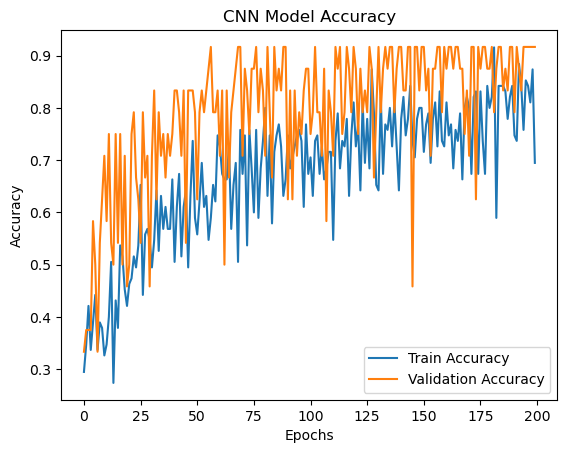

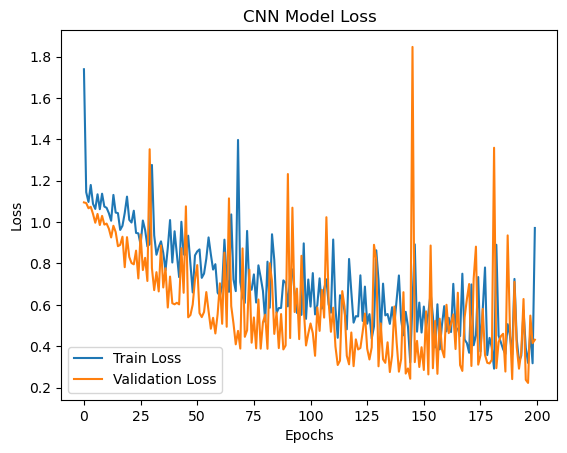

In [16]:
# Plot Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Model Accuracy')
plt.show()

# Plot Loss
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Model Loss')
plt.show()

# MODEL EVALUATION

# Prediction on a New Images

To demonstrate the model's practical application, a new image was preprocessed like the training data and fed into the model. The predicted class was obtained and compared with the actual class for evaluation. This process ensures consistency in testing and helps assess the model’s accuracy.

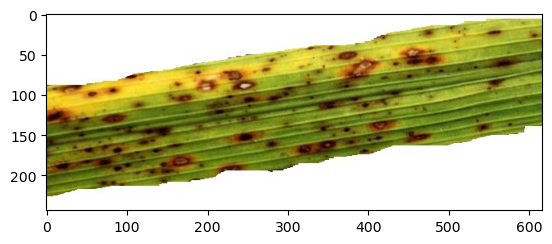

In [17]:
path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Brown Spot\DSC_0101.jpg"
img=plt.imread(path)
plt.imshow(img)
plt.show()
org_label = 'Brown Spot'

In [18]:
test_loss, test_acc = custom_cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9167 - loss: 0.2223
Test Accuracy: 91.67%
Test Loss: 0.2223


In [19]:
custom_cnn_model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9167 - loss: 0.2223


[0.22234392166137695, 0.9166666865348816]

In [20]:
img_label = ['Bacterial leaf blight','Brown spot','Leaf smut']

In [21]:
img=cv2.resize(img,(64,164))
img = img/255

In [22]:
x=tf.keras.preprocessing.image.array_to_img(img)
x=np.expand_dims(x,axis=0)

In [23]:
y_pred = custom_cnn_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


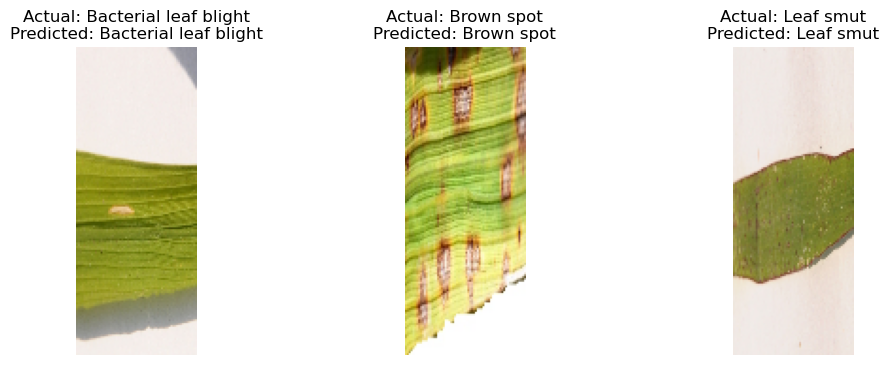

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for all images in X_test
predicted_probabilities = custom_cnn_model.predict(X_test)

# Get predicted and actual class indices
predicted_class_indices = np.argmax(predicted_probabilities, axis=1)  
actual_class_indices = np.argmax(y_test, axis=1)  

# Store unique class images
unique_classes = set()
selected_indices = []

# Collect one image per class
for i in range(len(X_test)):
    class_idx = actual_class_indices[i]
    if class_idx not in unique_classes:
        unique_classes.add(class_idx)
        selected_indices.append(i)
    if len(unique_classes) == 3:  # Stop when we have 3 different classes
        break

# Plot images with their predicted and actual labels
plt.figure(figsize=(12, 4))

for i, idx in enumerate(selected_indices):
    plt.subplot(1, 3, i + 1)
    
    # Ensure image is in correct format
    img = X_test[idx]

    # If the image is normalized (0-1 range), convert it back to 0-255
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)

    # Check if the image is in the wrong color space (BGR instead of RGB)
    if img.shape[-1] == 3:  # Ensure it's a 3-channel image
        img = img[:, :, ::-1]  # Convert BGR to RGB if needed

    plt.imshow(img)  # Show the corrected image
    plt.title(f"Actual: {img_label[actual_class_indices[idx]]}\nPredicted: {img_label[predicted_class_indices[idx]]}")
    plt.axis("off")

plt.show()


# Classification Report and Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.80      1.00      0.89         8
           Brown Spot       1.00      0.75      0.86         8
            Leaf Smut       1.00      1.00      1.00         8

             accuracy                           0.92        24
            macro avg       0.93      0.92      0.92        24
         weighted avg       0.93      0.92      0.92        24



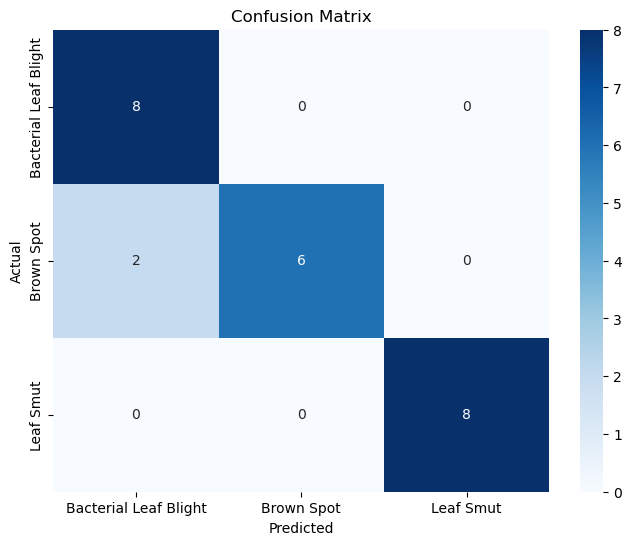

In [25]:
# Make Predictions
y_pred = custom_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class labels
class_labels = ['Bacterial Leaf Blight', 'Brown Spot', 'Leaf Smut']


# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# OTHER MODEL IMPLENTATION 

# Load and Pretrained VGG16 Model

In [26]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Set image dimensions
img_height = 64  
img_width = 164  

# Define dataset path
dataset_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data"


# Data Preprocessing

In [27]:
# Initialize lists
images = []
labels = []
class_names = os.listdir(dataset_path)  # Get class labels

# Loop through each class folder
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))  # Resize to (164, 64)
                images.append(image)
                labels.append(class_idx)

# Convert lists to NumPy arrays
x_data = np.array(images, dtype="float32") / 255.0  # Normalize
y_data = to_categorical(labels, num_classes=3)  # Convert labels to categorical

# Print shape
print("Dataset shape:", x_data.shape)  # Should be (num_samples, 64, 164, 3)
print("Labels shape:", y_data.shape)  # Should be (num_samples, 3)


Dataset shape: (119, 64, 164, 3)
Labels shape: (119, 3)


In [28]:
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split Data into Training and Testing Sets

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (95, 64, 164, 3) (95, 3)
Test shape: (24, 64, 164, 3) (24, 3)


# Build vGG16 Model

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set image dimensions
img_height = 164  # Height should be first
img_width = 64

# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(164, 64, 3))

# Build model
model_vgg16 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg16.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 5, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,026,435 (61.14 MB)

 Trainable params: 16,026,435 (61.14 MB)

 Non-trainable params: 0 (0.00 B)

# Data Augmentation

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)


# Train vgg16 model

In [32]:
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=50,  # Start with 50 epochs, increase if needed
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 875ms/step - accuracy: 0.3425 - loss: 1.3604 - val_accuracy: 0.3333 - val_loss: 1.1005
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - accuracy: 0.2492 - loss: 1.2499 - val_accuracy: 0.5417 - val_loss: 1.0666
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 840ms/step - accuracy: 0.3083 - loss: 1.2605 - val_accuracy: 0.3333 - val_loss: 1.0779
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 872ms/step - accuracy: 0.4482 - loss: 1.1417 - val_accuracy: 0.3750 - val_loss: 1.0463
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 943ms/step - accuracy: 0.3172 - loss: 1.1383 - val_accuracy: 0.5417 - val_loss: 0.9708
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 962ms/step - accuracy: 0.4042 - loss: 1.0733 - val_accuracy: 0.5000 - val_loss: 0.8959
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 971ms/step - accuracy: 0.4912 - loss: 0.9992 - val_accuracy: 0.7083 - val_loss: 0.7990
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step - accuracy: 0.4608 - loss: 1.0252 - val_accuracy: 0.4583 - val_loss:

# MODEL PLOT

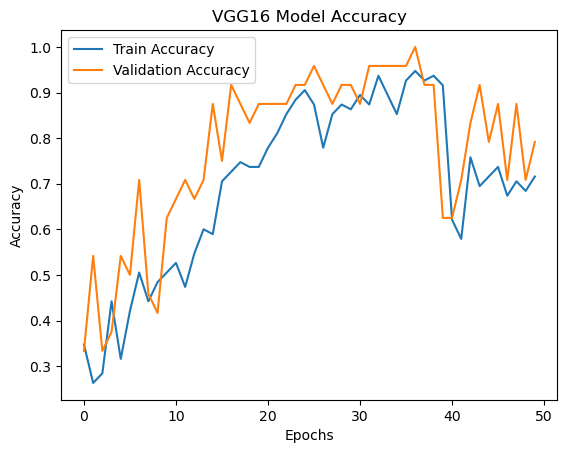

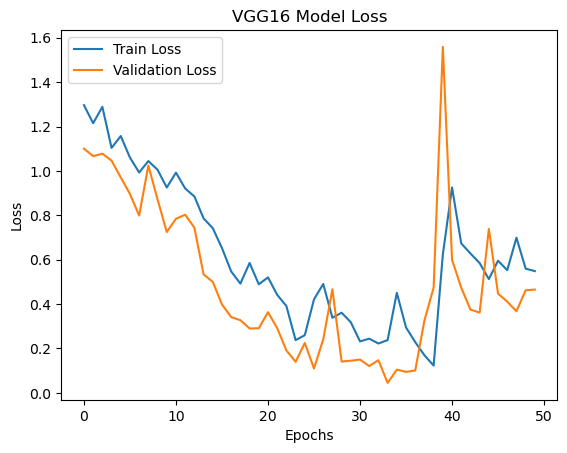

In [33]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGG16 Model Accuracy')
plt.show()

# Plot Loss
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('VGG16 Model Loss')
plt.show()


# Model Save

In [34]:
# Assuming 'model_vgg16' is your trained model
model_vgg16.save('model_vgg16.h5')


In [35]:
from tensorflow.keras.models import load_model

model_vgg16 = load_model('model_vgg16.h5')


# MODEL EVALUATION

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model_vgg16 = load_model('model_vgg16.h5')

# Load an image file to predict, resizing it to 224x224 pixels (input size for VGG16)
img_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Leaf smut\DSC_0512.jpg"
img = image.load_img(img_path, target_size=(164, 64))

# Convert the image to a numpy array and normalize it
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image (VGG16 expects pixel values in [0, 1])

# Make a prediction
predictions = model_vgg16.predict(img_array)

# Define the class labels
class_labels = ['Bacterial Leaf Blight', 'Brown Spot', 'Leaf Smut']

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label and confidence
print(f"Predicted class: {predicted_class_label} with confidence: {predictions[0][predicted_class_index]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted class: Leaf Smut with confidence: 0.53


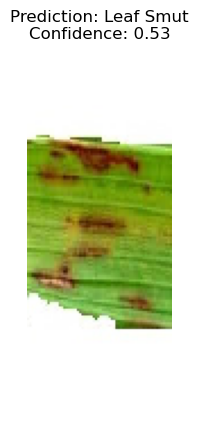

In [37]:
# Display the image along with the prediction as the title
plt.imshow(img)
plt.title(f"Prediction: {predicted_class_label}\nConfidence: {predictions[0][predicted_class_index]:.2f}")
plt.axis('off')
plt.show()

In [38]:
test_loss, test_acc = model_vgg16.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step - accuracy: 0.7917 - loss: 0.4654
Test Accuracy: 79.17%
Test Loss: 0.4654


# Classification Report and Confusion Matrix

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

# Select a model for prediction
selected_model = model_vgg16  # Change to model_vgg16 or model based on your choice

# Make predictions
y_pred = selected_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.80      1.00      0.89         8
           Brown spot       1.00      0.38      0.55         8
            Leaf smut       0.73      1.00      0.84         8

             accuracy                           0.79        24
            macro avg       0.84      0.79      0.76        24
         weighted avg       0.84      0.79      0.76        24

Confusion Matrix:
[[8 0 0]
 [2 3 3]
 [0 0 8]]


# Pretrained ResNet50 Model¶

In [40]:
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Data augmentaion 

In [41]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=16)


# Build ResNet50 model

In [42]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 base model (Width should be last in input shape)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 164, 3))

# Build the model
model_resnet = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_resnet.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 6, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,291,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,880,195 (113.98 MB)

 Trainable params: 29,827,075 (113.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Train ResNet50

In [43]:
history_resnet = model_resnet.fit(
    train_generator,
    epochs=200,  # Start with 50 epochs, increase if needed
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3702 - loss: 2.3127 - val_accuracy: 0.3333 - val_loss: 1.4207
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - accuracy: 0.4732 - loss: 1.9425 - val_accuracy: 0.3333 - val_loss: 1.1526
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 714ms/step - accuracy: 0.5865 - loss: 1.6432 - val_accuracy: 0.3333 - val_loss: 1.1410
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 735ms/step - accuracy: 0.6385 - loss: 1.0875 - val_accuracy: 0.3333 - val_loss: 1.1520
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 795ms/step - accuracy: 0.6654 - loss: 1.0049 - val_accuracy: 0.3333 - val_loss: 1.2125
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - accuracy: 0.7225 - loss: 0.8751 - val_accuracy: 0.3333 - val_loss: 1.4248
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 789ms/step - accuracy: 0.6549 - loss: 1.0411 - val_accuracy: 0.3333 - val_loss: 1.4901
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step - accuracy: 0.6701 - loss: 0.8887 - val_accuracy: 0.3333 - val

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 724ms/step - accuracy: 0.9940 - loss: 0.0846 - val_accuracy: 0.3333 - val_loss: 2.2979
Epoch 102/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.9869 - loss: 0.0558 - val_accuracy: 0.2917 - val_loss: 2.1086
Epoch 103/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 728ms/step - accuracy: 0.9790 - loss: 0.0666 - val_accuracy: 0.2917 - val_loss: 2.0358
Epoch 104/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - accuracy: 0.9531 - loss: 0.1520 - val_accuracy: 0.2917 - val_loss: 2.0050
Epoch 105/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 714ms/step - accuracy: 0.9770 - loss: 0.0488 - val_accuracy: 0.2917 - val_loss: 1.8760
Epoch 106/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - accuracy: 0.9186 - loss: 0.4166 - val_accuracy: 0.2917 - val_loss: 1.7648
Epoch 107/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.9170 - loss: 0.1349 - val_accuracy: 0.3750 - val_loss: 1.6119
Epoch 108/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.9710 - loss: 0.0970 - val_accuracy: 0.3750 -

# Model Plot

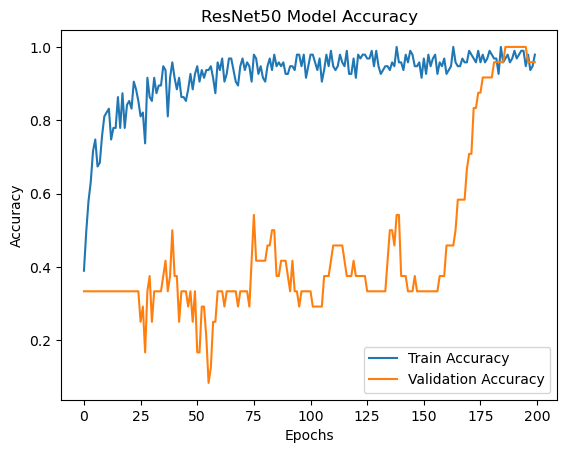

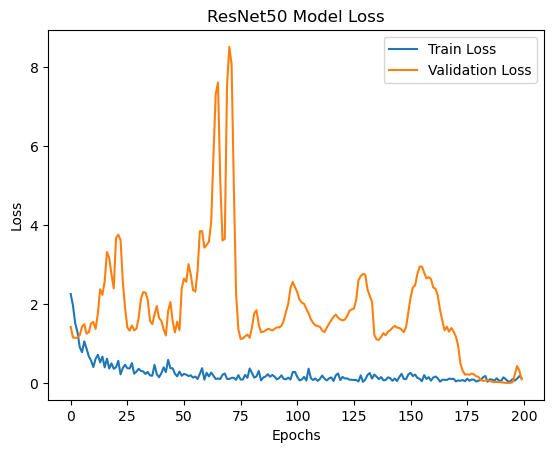

In [44]:
# Plot Accuracy
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50 Model Accuracy')
plt.show()

# Plot Loss
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet50 Model Loss')
plt.show()


# Model Evaluation

In [45]:
test_loss, test_acc = model_resnet.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9583 - loss: 0.0945
Test Accuracy: 95.83%
Test Loss: 0.0945


# Model Predictions

In [46]:
# Assuming 'model_vgg16' is your trained model
model_resnet.save('model_resnet.h5')


In [47]:
from tensorflow.keras.models import load_model

model_resnet = load_model('model_resnet.h5')


In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load your custom trained rice leaf model (make sure this model is trained on rice leaf images)
model_riceleaf = load_model('model_resnet.h5')

# Set the target image size (must match what was used during training, e.g., 224x224)
IMG_SIZE = (64, 164)

# Specify the path to your rice leaf image (adjust the path accordingly)
img_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Bacterial leaf blight\DSC_0702.jpg"

# Load the image and resize it to the target size
img = image.load_img(img_path, target_size=IMG_SIZE)

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's input shape (1, IMG_SIZE[0], IMG_SIZE[1], 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image pixels to [0, 1] if your model was trained with normalized images
img_array /= 255.0

# Make a prediction using the custom model
predictions = model_riceleaf.predict(img_array)

# Define your rice leaf class labels (ensure these match the order used during training)
class_labels = ['Bacterial leaf blight', 'Brown Spot', 'Leaf Smut']

# Determine the predicted class index and label
predicted_index = np.argmax(predictions)
predicted_label = class_labels[predicted_index]
confidence = predictions[0][predicted_index]

# Print the prediction and its confidence
print(f"Predicted class: {predicted_label} with confidence: {confidence:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
Predicted class: Bacterial leaf blight with confidence: 1.00


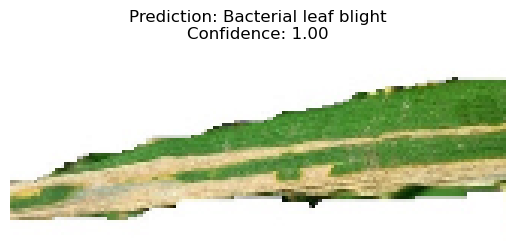

In [49]:
# Display the image along with the prediction results
plt.imshow(img)
plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

# Classification Report and Confusion Matrix

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

# Select a model for prediction
selected_model = model_resnet  # Change to model_vgg16 or model based on your choice

# Make predictions
y_pred = selected_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.89      1.00      0.94         8
           Brown spot       1.00      0.88      0.93         8
            Leaf smut       1.00      1.00      1.00         8

             accuracy                           0.96        24
            macro avg       0.96      0.96      0.96        24
         weighted avg       0.96      0.96      0.96        24

Confusion Matrix:
[[8 0 0]
 [1 7 0]
 [0 0 8]]


# MobileNet Model

In [51]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [52]:
# Set image dimensions (Ensure width comes last)
img_height = 224  
img_width = 224

# Define dataset path
dataset_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data"

# Initialize lists
images = []
labels = []
class_names = sorted(os.listdir(dataset_path))  # Get sorted class labels

# Loop through each class folder
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))  # Resize to (164, 64)
                images.append(image)
                labels.append(class_idx)

# Convert lists to NumPy arrays
x_data = np.array(images, dtype="float32") / 255.0  # Normalize
y_data = to_categorical(labels, num_classes=3)  # Convert labels to categorical

# Print dataset shape
print("Dataset shape:", x_data.shape)  # Should be (num_samples, 64, 164, 3)
print("Labels shape:", y_data.shape)  # Should be (num_samples, 3)


Dataset shape: (119, 224, 224, 3)
Labels shape: (119, 3)


In [53]:
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


Train shape: (95, 224, 224, 3) (95, 3)
Test shape: (24, 224, 224, 3) (24, 3)


# Class Weight

In [55]:
from sklearn.utils import class_weight
import numpy as np

# Assuming y_true_classes is your array of true labels (not one-hot encoded)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true_classes),
    y=y_true_classes
)

# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Print class weights for verification
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}


# Data Augmentation

In [56]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Build MobileNetV2 Model

In [58]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 949ms/step - accuracy: 0.2985 - loss: 2.2890 - val_accuracy: 0.6250 - val_loss: 0.8113
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 0.6532 - loss: 0.7977 - val_accuracy: 0.9167 - val_loss: 0.4023
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 0.7096 - loss: 0.5784 - val_accuracy: 0.9583 - val_loss: 0.2873
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.8142 - loss: 0.4264 - val_accuracy: 1.0000 - val_loss: 0.1674
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - accuracy: 0.8913 - loss: 0.3086 - val_accuracy: 1.0000 - val_loss: 0.1337
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.9215 - loss: 0.2328 - val_accuracy: 1.0000 - val_loss: 0.1061
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - accuracy: 0.9463 - loss: 0.1937 - val_accuracy: 1.0000 - val_loss: 0.0768
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.9725 - loss: 0.1508 - val_accuracy: 1.0000 - val_loss:

In [59]:
# Fit the model with class weights
model.fit(x_train, y_train, class_weight=class_weights_dict, epochs=10, batch_size=32)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.9856 - loss: 0.0952
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 1.0000 - loss: 0.0572
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.9908 - loss: 0.0586
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.9947 - loss: 0.0404
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 1.0000 - loss: 0.0477
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.9764 - loss: 0.0722
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.9738 - loss: 0.0490
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 1.0000 - loss: 0.0205
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 1.0000 - loss: 0.0351
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 1.0000 - loss: 0.0263


In [61]:
# Print model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)

In [62]:
from tensorflow.keras.regularizers import l2

model_MobileNetV2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


# Train MobileNetV2 model

In [64]:
# Compile the model
model_MobileNetV2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model_MobileNetV2.summary()
model_MobileNetV2.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4580 - loss: 3.8162 - val_accuracy: 0.3750 - val_loss: 3.6797 - learning_rate: 1.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.3834 - loss: 3.7236 - val_accuracy: 0.4167 - val_loss: 3.4875 - learning_rate: 1.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 0.4750 - loss: 3.5592 - val_accuracy: 0.5833 - val_loss: 3.3513 - learning_rate: 1.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step - accuracy: 0.4113 - loss: 3.4931 - val_accuracy: 0.5417 - val_loss: 3.2475 - learning_rate: 1.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.5366 - loss: 3.4302 - val_accuracy: 0.6250 - val_loss: 3.1582 - learning_rate: 1.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.5093 - loss: 3.4237 - val_accuracy: 0.6667 - val_loss: 3.0818 - learning_rate: 1.0000e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - accuracy: 0.6269 - loss: 3.

# Model Save

In [65]:
model_MobileNetV2.save('model_MobileNetV2.h5')


In [66]:
from tensorflow.keras.models import load_model
model_loaded = load_model('model_MobileNetV2.h5')

# Model Evaluation

In [67]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load your custom MobileNetV2-based model
model_MobileNetV2 = load_model('model_MobileNetV2.h5')

# Set the target image size (must match the input size used during training)
IMG_SIZE = (224, 224)

# Specify the path to your image file (update this path accordingly)
img_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Bacterial leaf blight\DSC_0383.jpg"

# Load the image and resize it to the target size
img = image.load_img(img_path, target_size=IMG_SIZE)

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (assuming the model was trained on normalized images)
img_array /= 255.0

# Make a prediction using your MobileNetV2-based model
predictions = model_MobileNetV2.predict(img_array)

# Define your class labels (ensure these match the order used during training)
class_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Determine the predicted class index and corresponding label
predicted_index = np.argmax(predictions)
predicted_label = class_labels[predicted_index]
confidence = predictions[0][predicted_index]

# Print the prediction and its confidence
print(f"Predicted class: {predicted_label} with confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
Predicted class: Bacterial leaf blight with confidence: 0.87


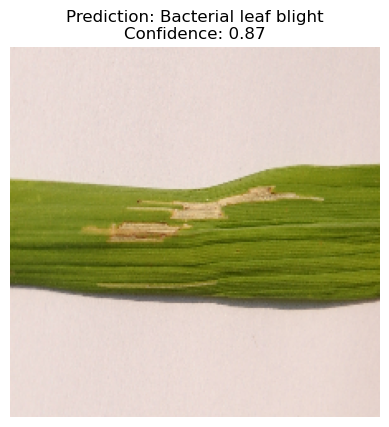

In [68]:
# Display the image along with the prediction results
plt.imshow(img)
plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

In [69]:
# Evaluate the model
test_loss, test_acc = model_MobileNetV2.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9583 - loss: 2.5282
Test Accuracy: 0.96


# Test with Multiple Images

# Bacterial leaf blight

In [70]:
import os

test_image_dir = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Bacterial leaf blight"
for img_name in os.listdir(test_image_dir):
    img_path = os.path.join(test_image_dir, img_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model_MobileNetV2.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Image: {img_name}, Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: DSC_0365.JPG, Predicted class: Leaf smut, Confidence: 0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0366.jpg, Predicted class: Bacterial leaf blight, Confidence: 0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: DSC_0367.JPG, Predicted class: Bacterial leaf blight, Confidence: 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0370.jpg, Predicted class: Bacterial leaf blight, Confidence: 0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: DSC_0372.JPG, Predicted class: Bacterial leaf blight, Confidence: 0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: DSC_0373.JPG, Predicted class: Bacterial leaf blight, Confidence: 0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0374.JPG, Predicted class: Brown spot, Confidence: 0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: DSC_0375.JPG, Predicted class: Bacterial leaf blight, Confidence: 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0376.JPG, Predicted class: Bacterial leaf blig

# Brown spot

In [73]:
import os

test_image_dir = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Brown spot"
for img_name in os.listdir(test_image_dir):
    img_path = os.path.join(test_image_dir, img_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model_MobileNetV2.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Image: {img_name}, Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: DSC_0100.jpg, Predicted class: Brown spot, Confidence: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: DSC_0101.jpg, Predicted class: Brown spot, Confidence: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: DSC_0104.jpg, Predicted class: Brown spot, Confidence: 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: DSC_0105.jpg, Predicted class: Brown spot, Confidence: 0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: DSC_0106.jpg, Predicted class: Brown spot, Confidence: 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: DSC_0107.jpg, Predicted class: Brown spot, Confidence: 0.89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0108.jpg, Predicted class: Brown spot, Confidence: 0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: DSC_0109.jpg, Predicted class: Brown spot, Confidence: 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: DSC_0110.jpg, Predicted class: Brown spot, Confidence: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: DSC_0111.j

# Leaf Smut

In [74]:
import os

test_image_dir = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data\Leaf smut"
for img_name in os.listdir(test_image_dir):
    img_path = os.path.join(test_image_dir, img_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model_MobileNetV2.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Image: {img_name}, Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0293.JPG, Predicted class: Leaf smut, Confidence: 0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: DSC_0308.JPG, Predicted class: Leaf smut, Confidence: 0.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0309.JPG, Predicted class: Leaf smut, Confidence: 0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: DSC_0310.JPG, Predicted class: Leaf smut, Confidence: 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0312.JPG, Predicted class: Leaf smut, Confidence: 0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0313.JPG, Predicted class: Leaf smut, Confidence: 0.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0314.JPG, Predicted class: Leaf smut, Confidence: 0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: DSC_0315.jpg, Predicted class: Leaf smut, Confidence: 0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: DSC_0316.JPG, Predicted class: Leaf smut, Confidence: 0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: DSC_0317.JPG, Predi

# Classification Report and Confusion Matrix¶

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

# Select a model for prediction
selected_model = model_MobileNetV2  # Change to model_vgg16 or model based on your choice

# Make predictions
y_pred = selected_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         8
           Brown spot       0.89      1.00      0.94         8
            Leaf smut       1.00      0.88      0.93         8

             accuracy                           0.96        24
            macro avg       0.96      0.96      0.96        24
         weighted avg       0.96      0.96      0.96        24



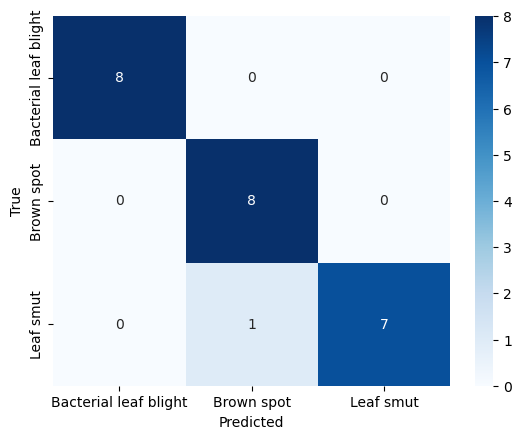

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Hyperparameter tuning 

In [77]:
pip install tensorflow keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --------------- ----------------------- 51.2/129.1 kB 660.6 kB/s eta 0:00:01
   --------------- ----------------------- 51.2/129.1 kB 660.6 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 849.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# MobileNetV2 MODEL FOR HYPERPARAMETER TUNING

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Define the HyperModel
class MobileNetV2HyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        # Hyperparameters to tune
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)

        # Load MobileNetV2 with pre-trained weights, excluding the top layers
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        base_model.trainable = False  # Freeze the base model

        # Build the model
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(units=dense_units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
        return model

# Define the input shape and number of classes
input_shape = (128, 128, 3)  # CIFAR-10 images are 32x32 with 3 color channels
num_classes = 3

# Initialize the HyperModel
hypermodel = MobileNetV2HyperModel(input_shape=input_shape, num_classes=num_classes)

# Initialize the RandomSearch tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='mobilenetv2_tuning',
    project_name='cifar10'
)

# Perform the hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal number of units in the dense layer i
\s {best_hps.get('dense_units')}.
""")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=25, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Reloading Tuner from mobilenetv2_tuning\cifar10\tuner0.json

The optimal learning rate is 0.001.
The optimal dropout rate is 0.1.
The optimal number of units in the dense layer i
\s 512.

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3024 - loss: 1.7319 - val_accuracy: 0.5263 - val_loss: 1.3114
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7305 - loss: 0.5792 - val_accuracy: 0.5263 - val_loss: 0.8490
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9463 - loss: 0.1223 - val_accuracy: 0.6316 - val_loss: 1.0466
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9634 - loss: 0.0906 - val_accuracy: 0.5789 - val_loss: 0.9716
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0462 - val_accuracy: 0.6842 - val_loss: 0.7088
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9817 - loss: 0.0406 - val_accuracy: 0.6842 - val_loss: 0.5646
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accurac

In [23]:
# Generate predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut']))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.80      1.00      0.89         8
           brown_spot       1.00      0.75      0.86         8
            leaf_smut       0.88      0.88      0.88         8

             accuracy                           0.88        24
            macro avg       0.89      0.88      0.87        24
         weighted avg       0.89      0.88      0.87        24



Confusion Matrix:
[[8 0 0]
 [1 6 1]
 [1 0 7]]


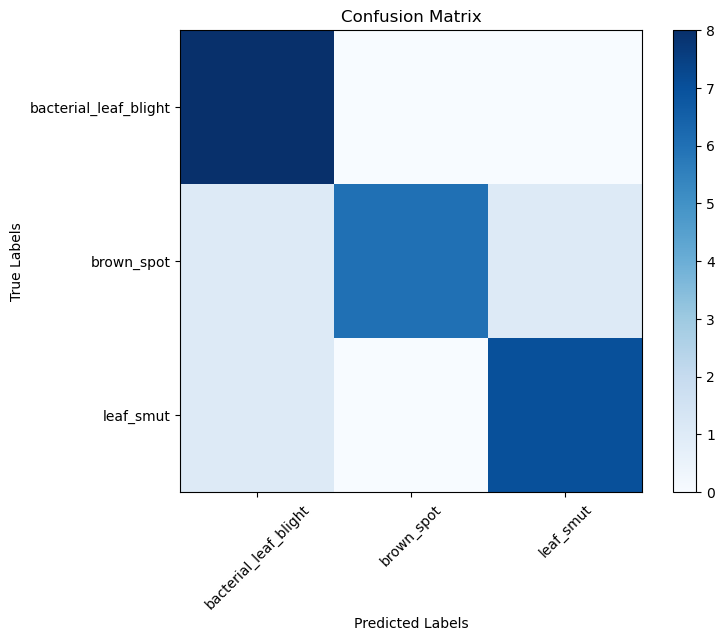

In [22]:
# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_labels)
print(conf_matrix)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(3), labels=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'], rotation=45)
plt.yticks(ticks=np.arange(3), labels=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# CNN MODEL FOR HYPERPARAMETER TUNING

In [3]:
!pip install keras-tuner tensorflow numpy matplotlib scikit-learn opencv-python


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [3]:
# Define image size
IMG_SIZE = 128
NUM_CLASSES = 3  # Number of disease categories

# Path to dataset
dataset_path = r"C:\Users\Pushparaj\datemites\project datamites\PRCP-1001-RiceLeaf\Data"

# Define class labels
class_labels = {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}

# Initialize lists for images and labels
images = []
labels = []

# Load images
for class_name, label in class_labels.items():
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)  # Read image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels, dtype="int")

# One-hot encode labels
labels = to_categorical(labels, num_classes=NUM_CLASSES)

# Split into training (80%) and testing (20%) sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print dataset shapes
print(f"Training Set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing Set: {x_test.shape}, Labels: {y_test.shape}")


Training Set: (95, 128, 128, 3), Labels: (95, 3)
Testing Set: (24, 128, 128, 3), Labels: (24, 3)


In [4]:
def build_model(hp):
    model = keras.Sequential()
    
    # Convolutional Layer 1
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten Layer
    model.add(layers.Flatten())

    # Dense Layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))

    # Dropout Layer
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    # Compile Model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [5]:
# Define Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='kt_hyperband',
    project_name='cnn_rice_leaf'
)

# Early Stopping
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the search
tuner.search(x_train, y_train, validation_split=0.2, epochs=20, callbacks=[stop_early])


Trial 30 Complete [00h 01m 37s]
val_accuracy: 0.7894737124443054

Best val_accuracy So Far: 0.7894737124443054
Total elapsed time: 00h 23m 10s


In [6]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Conv1 Filters: {best_hps.get('conv1_filters')}
- Conv1 Kernel Size: {best_hps.get('conv1_kernel')}
- Conv2 Filters: {best_hps.get('conv2_filters')}
- Conv2 Kernel Size: {best_hps.get('conv2_kernel')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Best Hyperparameters:
- Conv1 Filters: 128
- Conv1 Kernel Size: 5
- Conv2 Filters: 192
- Conv2 Kernel Size: 5
- Dense Units: 384
- Dropout Rate: 0.2
- Learning Rate: 0.0001



In [7]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(x_train, y_train, validation_split=0.2, epochs=30, callbacks=[stop_early])


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2956 - loss: 2.5635 - val_accuracy: 0.2105 - val_loss: 1.4290
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3232 - loss: 1.2085 - val_accuracy: 0.4211 - val_loss: 1.1130
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3351 - loss: 1.1245 - val_accuracy: 0.4737 - val_loss: 1.0877
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5446 - loss: 1.0589 - val_accuracy: 0.3158 - val_loss: 1.1244
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5066 - loss: 1.0465 - val_accuracy: 0.3158 - val_loss: 1.1245
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5512 - loss: 1.0218 - val_accuracy: 0.3158 - val_loss: 1.1005
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5917 - loss: 0.9831 - val_accuracy: 0.3158 - val_loss: 1.1692
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6190 - loss: 0.9290 - val_accuracy: 0.5263 - val_loss: 1.0261
Epoch 9/30
3/3 ━

In [8]:
# Evaluate on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7500 - loss: 0.4829
Test Accuracy: 75.00%


In [9]:
# Save the best model
best_model.save("best_rice_leaf_cnn.h5")

# Load the saved model
from tensorflow.keras.models import load_model
model = load_model("best_rice_leaf_cnn.h5")


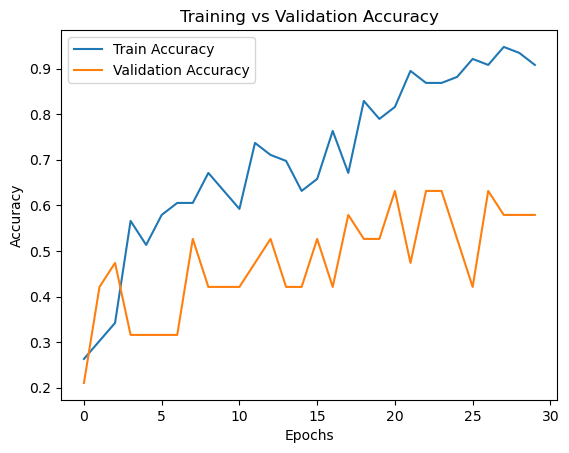

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Get model predictions
y_pred_probs = best_model.predict(x_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels
y_true = np.argmax(y_test, axis=1)         # Convert true labels from one-hot


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


In [12]:
# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels.keys()))


Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       0.78      0.88      0.82         8
           Brown spot       0.67      0.75      0.71         8
            Leaf smut       0.83      0.62      0.71         8

             accuracy                           0.75        24
            macro avg       0.76      0.75      0.75        24
         weighted avg       0.76      0.75      0.75        24



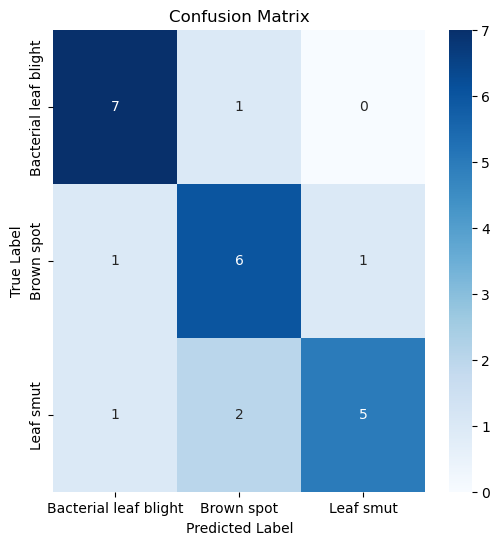

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Retrain CNN Model with Best Hyperparameters

In [14]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# Define model builder function
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(hp.Choice('filters', [32, 64, 128]), (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(hp.Choice('filters', [32, 64, 128]), (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(hp.Choice('units', [64, 128, 256]), activation='relu'),
        layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        layers.Dense(3, activation='softmax')  # 3 classes
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='rice_leaf_disease'
)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Retrain best model
best_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))


Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 00m 57s
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.3009 - loss: 4.3876 - val_accuracy: 0.3333 - val_loss: 3.9053
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.3403 - loss: 3.4930 - val_accuracy: 0.3333 - val_loss: 1.2370
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.4033 - loss: 1.1704 - val_accuracy: 0.3333 - val_loss: 1.0653
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.3576 - loss: 1.0861 - val_accuracy: 0.5417 - val_loss: 0.9277
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.5707 - loss: 0.9576 - val_accuracy: 0.6667 - val_loss: 0.8119
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.6256 - loss: 0.8190 - val_accuracy: 0.7083 - val_loss: 0.7691
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6623 - loss: 0.8217 - val_accuracy: 0.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict classes
y_pred_probs = best_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Updated Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Bacterial leaf blight", "Brown spot", "Leaf smut"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Updated Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       0.64      0.88      0.74         8
           Brown spot       0.57      0.50      0.53         8
            Leaf smut       1.00      0.75      0.86         8

             accuracy                           0.71        24
            macro avg       0.74      0.71      0.71        24
         weighted avg       0.74      0.71      0.71        24



In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

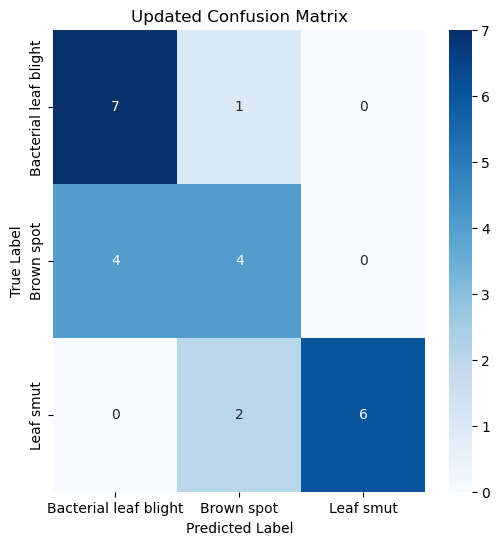

In [17]:
# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Bacterial leaf blight", "Brown spot", "Leaf smut"],
            yticklabels=["Bacterial leaf blight", "Brown spot", "Leaf smut"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix")
plt.show()


# MODEL COMPARISON REPORT

In [34]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [35]:
from tabulate import tabulate

data = [
    ("f1 Score", 0.75, 0.88)
]

headers = ["Names ", "CNN", "MobileNetV2"]

# Generate the table
table = tabulate(data, headers=headers, tablefmt="grid")

In [36]:
# Print the table
print(table)

+----------+-------+---------------+
| Names    |   CNN |   MobileNetV2 |
+==========+=======+===============+
| f1 Score |  0.75 |          0.88 |
+----------+-------+---------------+


# Interpretation:

F1 Score Analysis:

The higher F1 score (0.88) of MobileNetV2 indicates better balance between precision and recall compared to the CNN model (0.75).
MobileNetV2 likely generalizes better on the given dataset, reducing misclassifications.

Efficiency & Complexity:
CNN Model: Custom CNNs can be designed to be lightweight but may require extensive tuning.
MobileNetV2: Optimized for efficiency, with depthwise separable convolutions, making it faster and 
lightweight compared to traditional CNNs.

Suitability for Deployment:
MobileNetV2 is the better choice for deployment due to its balance of accuracy, efficiency, and lower computational cost.

# Final Recommendation:
MobileNetV2 is the best choice for deployment due to its high accuracy, lightweight nature, and flexibility across devices.

# CHALLENGES FACED

Overfitting:

Since the dataset is small (120 images total), the model might memorize the training images instead of learning general patterns.
Leads to high training accuracy but poor generalization on validation/test data.

Class Imbalance:

If one disease class has significantly more images than others, the model may become biased toward the dominant class.
Can result in poor recall for minority classes, meaning some diseases might not be correctly identified.

Validation Fluctuation:

With a small dataset, validation accuracy/loss can fluctuate greatly due to random batch selection.
Causes inconsistency in model evaluation, making it hard to determine if the model is improving.

Underfitting:

If the model is too simple or not trained well, it may fail to learn meaningful features from the images.
Results in low training and validation accuracy.

# Model for Real-Life Deployment

Flexibility:
   Can be easily deployed using TensorFlow Lite (for mobile), ONNX (for cross-platform), or TensorFlow Serving (for cloud APIs).
Supports Flask/FastAPI for API-based deployment and can be integrated with web or mobile apps

Low Hardware Requirements:
    Performs well on low-power devices like Raspberry Pi, Jetson Nano, or mobile devices.
    Can run efficiently without needing expensive GPUs, making it cost-effective for large-scale deployment.

Future Scalability & Optimization:
    Supports further tuning via pruning, quantization, and transfer learning to enhance efficiency.
    Compatible with cloud AI services (AWS, GCP, Azure) for large-scale deployment.

# Conclusion

Based on the results, MobileNetV2 is the most suitable model for deployment due to its superior F1 Score and efficiency.
Further improvements to the CNN model could make it viable in the future. The deployment strategy should focus on cloud and
edge-based solutions for scalability and accessibility.